# ***Setting up environment***


In [1]:
# Get access to drive folder
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)
FOLDERNAME = 'Colab Notebooks/Machine Learning Course - Final Project'
assert FOLDERNAME is not None , "[!] Enter the foldername"

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Machine Learning Course - Final Project


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

---
# ***Process and split data***

In [3]:
from Covid19_Dataset import Covid19_Dataset
from sklearn.model_selection import train_test_split

# get and process covid-19 data
dataset = Covid19_Dataset()
covid = dataset.process_and_clean()
print(covid.shape)

# split the data to train(90%), validation(5%) and test(5%)
train, validation = train_test_split(covid, test_size=0.1, shuffle=True)
validation, test = train_test_split(validation, test_size=0.5, shuffle=True)

validation_y = validation.AT_RISK.to_numpy()
validation_x = validation.drop(columns = ['AT_RISK']).to_numpy()

test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()

(388878, 18)


---
# ***Calculate results***

In [4]:
# retuen F-measure (F1-score) for given data and labels
def get_Fmeasure(prediction, labels):

  # Compares the prediction of each object to its label
  true_positive = np.sum((prediction + labels) == 2)
  false_positive = np.sum((labels - prediction) == -1)
  false_negative = np.sum((prediction - labels) == -1)
  positive = np.count_nonzero(labels == 1)
  negative = len(labels)-positive

  # Calculate F-measure
  accuracy = 100*np.sum(prediction == labels)/len(labels)
  recall = true_positive / (true_positive + false_negative)
  precision = true_positive / (true_positive + false_positive)
  eval = 2*(precision * recall) / (precision + recall)
  return eval

---
# ***K-Nearest Neighbors***
The K-Nearest Neighbours is non-linear classifier in which an object is classified to the class most common among its k nearest neighbours in the train set. The hyperparameters for the KNN algorithm are the value of k and the distance function that calculates the distance between two objects. 

In [5]:
from KNearestNeighbor import KNearestNeighbor

# undersampling the train set
atrisk = train[train.AT_RISK==1][:2000]
nonrisk = train[train.AT_RISK==0][:2000]
part_train = pd.concat([nonrisk, atrisk])
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

# set optional knn hyperparameters
k_choices = [1, 3, 5, 9, 13, 17, 23, 31]
dist_func = ["l1", "l2", "linf"]
knn_fmeasures = {}
knn_best_result = 0

for k in k_choices:
    knn_fmeasures[k] = np.zeros(len(dist_func))
    for (i, func) in enumerate(dist_func):
        # create a kNN classifier instance and compute the prediction
        knn_classifier = KNearestNeighbor()
        knn_classifier.train(train_x, train_y)
        pred_y = knn_classifier.predict(validation_x, k=k, dist_func=func) 

        # calculate F-measures and save best model
        knn_fmeasures[k][i] = get_Fmeasure(pred_y, validation_y)
        if knn_fmeasures[k][i] > knn_best_result:
            knn_best_result = knn_fmeasures[k][i]
            knn_best_model = knn_classifier

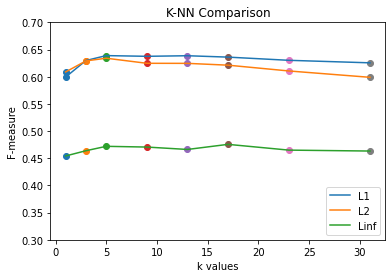

best result for: k = 5, distance function = l1, F-measure = 0.638849


In [6]:
# plot the results
l1, l2, linf = [], [], []
for k in k_choices:
    fmeasures = knn_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(knn_fmeasures[k][0])
    l2.append(knn_fmeasures[k][1])
    linf.append(knn_fmeasures[k][2])

# create line between all k values for each distance function
plt.errorbar(k_choices, l1, label ='L1')
plt.errorbar(k_choices, l2, label ='L2')
plt.errorbar(k_choices, linf, label ='Linf')
plt.legend(loc ='lower right')

plt.title('K-NN Comparison')
plt.xlabel('k values')
plt.ylabel('F-measure')
plt.ylim(0.3, 0.7)
plt.show()

# print best model parameters
print('best result for: k = %d, distance function = %s, F-measure = %f' % (knn_best_model.getK(), knn_best_model.get_func(), knn_best_result))

---
# ***SVM***
SVM is a classifier that separates data points using a linear hyperplane with the largest amount of margin between the two classes in the train set. SVM can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping the inputs into high-dimensional feature spaces.

In [22]:
from sklearn.svm import SVC

# split the data to x and y
part_train, _ = train_test_split(train, test_size=0.9, shuffle=True)
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

# set all SVM kernel options
kernels = ["linear", "poly", "rbf"]
svm_fmeasures = {}
svm_best_result = 0

for kernel in kernels:
    # create a SVM classifier instance and compute the prediction
    svm_classifier = SVC(kernel=kernel, degree=8, class_weight='balanced')
    svm_classifier.fit(train_x, train_y)
    y_pred = svm_classifier.predict(validation_x)

    # calculate F-measures and save best model
    svm_fmeasures[kernel] = get_Fmeasure(y_pred, validation_y)
    if svm_fmeasures[kernel] > svm_best_result:
        svm_best_result = svm_fmeasures[kernel]
        svm_best_model = svm_classifier

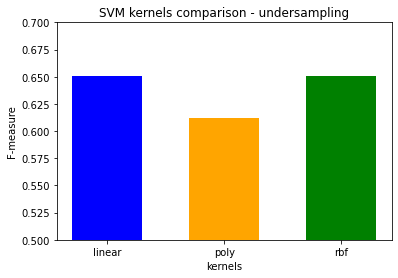

best result for: kernel = rbf, F-measure = 0.650455


In [23]:
# plot all the results
plt.bar(svm_fmeasures.keys(), svm_fmeasures.values(), color=['blue', 'orange', 'green', 'red'], width=.6)
plt.title('SVM kernels comparison - undersampling')
plt.xlabel('kernels')
plt.ylabel('F-measure')
plt.ylim(0.5, 0.7)
plt.show()

# print best model parameters
print('best result for: kernel = %s, F-measure = %f' % (svm_best_model.get_params()['kernel'], svm_best_result))

---
# ***Decision Tree***
A decision tree is a flowchart-like structure in which each internal node represents a "test" on a feature, each branch represents the outcome of the test, and each leaf node represents a class label. The paths from root to leaf represent classification rules. The decision tree algorithm uses heuristic functions for selecting the splitting criterion that partition data into the best possible manner.

In [26]:
from sklearn.tree import DecisionTreeClassifier

# undersampling the train set
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

# set Decision Tree parameters
heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [5, 7, 11, 13, 17]
dt_fmeasures = {}
dt_best_result = 0

for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:
        # create a Decision Tree classifier instance and compute the prediction
        dt_classifier = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        dt_classifier.fit(train_x, train_y)
        y_pred = dt_classifier.predict(validation_x)

        # calculate F-measures and save best model
        dt_fmeasures[d][i] = get_Fmeasure(y_pred, validation_y)
        if dt_fmeasures[d][i] > dt_best_result:
            dt_best_result = dt_fmeasures[d][i]
            dt_best_model = dt_classifier
        i=i+1

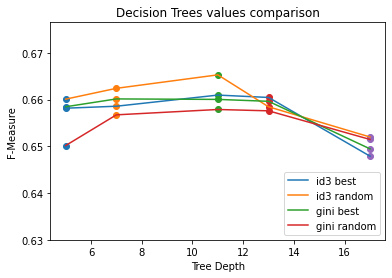

best result for: heuristic = entropy, splitter = random, max depth = 11, F-measure = 0.665275


In [27]:
# plot the results
l1, l2, l3, l4 = [], [], [], []
for k in dt_fmeasures.keys():
    fmeasures = dt_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(dt_fmeasures[k][0])
    l2.append(dt_fmeasures[k][1])
    l3.append(dt_fmeasures[k][2])
    l4.append(dt_fmeasures[k][3])

# create line for each of the four models
plt.errorbar(max_depth, l1, label ='id3 best')
plt.errorbar(max_depth, l2, label ='id3 random')
plt.errorbar(max_depth, l3, label ='gini best')
plt.errorbar(max_depth, l4, label ='gini random')
plt.legend(loc ='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.ylim(0.630, 0.6765)
plt.show()

# print best model parameters
params = dt_best_model.get_params()
print('best result for: heuristic = %s, splitter = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['splitter'], params['max_depth'], dt_best_result))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.136498 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.136498 to fit



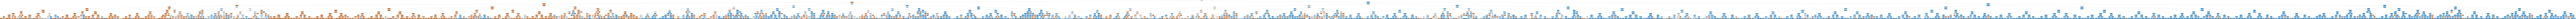

In [11]:
# plot the best best model decision tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dt_best_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

---
# ***Random Forest***
Random forests constructs multitude decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. Random forests generally outperform decision trees

In [31]:
from sklearn.ensemble import RandomForestClassifier

# undersampling the train set
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

# set Random Forest parameters
heuristics = ["entropy", "gini"]
max_depth = [3, 5, 7, 11, 13, 15, 17]
rf_fmeasures = {}
rf_best_result = 0
for j in range(5):
    for d in max_depth:
        rf_fmeasures[d] = np.zeros(len(heuristics))
        for (i, heuristic) in enumerate(heuristics):
            # create a Random Forest classifier instance and compute the prediction
            rf_classifier = RandomForestClassifier(n_estimators=100, criterion=heuristic, max_depth=d, class_weight='balanced')
            rf_classifier.fit(train_x, train_y)
            y_pred = rf_classifier.predict(validation_x)

            # calculate F-measures and save best model
            rf_fmeasures[d][i] = get_Fmeasure(y_pred, validation_y)
            if rf_fmeasures[d][i] > rf_best_result:
                rf_best_result = rf_fmeasures[d][i]
                rf_best_model = rf_classifier   

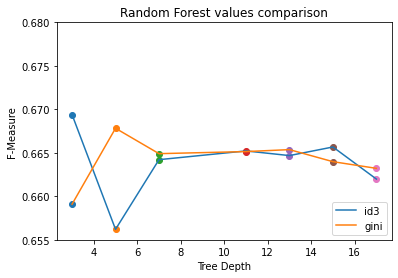

best result for: heuristic = gini, max depth = 3, F-measure = 0.674615


In [32]:
# plot the results
l1, l2 = [], []
for k in rf_fmeasures.keys():
    fmeasures = rf_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(rf_fmeasures[k][0])
    l2.append(rf_fmeasures[k][1])

# create line for each  models
plt.errorbar(max_depth, l1, label ='id3')
plt.errorbar(max_depth, l2, label ='gini')
plt.legend(loc ='lower right')
plt.title('Random Forest values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.ylim(0.655, 0.68)
plt.show()

# print best model parameters
params = rf_best_model.get_params()
print('best result for: heuristic = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['max_depth'], rf_best_result))

---
# ***Multilayer Perceptron***
An MLP model consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.

In [35]:
from sklearn.neural_network import MLPClassifier

# undersampling the train set
atrisk = train[train.AT_RISK==1][:20000]
nonrisk = train[train.AT_RISK==0][:20000]
part_train = (pd.concat([nonrisk, atrisk])).sample(frac = 1)
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

# set MLP parameters
layers = [(100,50,30,10,5), (15,10,5,10,15), (20,20,20,20), (10)]
optimizers = ['adam', 'sgd']
mlp_fmeasures = {}
mlp_best_result = 0

for (i, opt) in  enumerate(optimizers):
    mlp_fmeasures[i] = np.zeros(len(layers))
    for (j, layer) in enumerate(layers):
        # create a Logistic Regression classifier instance and compute the prediction
        mlp_classifier = MLPClassifier(hidden_layer_sizes = layer,
                                          solver = opt,
                                          learning_rate ='adaptive',
                                          max_iter = 5000)
        mlp_classifier.fit(train_x, train_y)
        y_pred = mlp_classifier.predict(validation_x)

        # calculate F-measures and save best model
        mlp_fmeasures[i][j] = get_Fmeasure(y_pred, validation_y)
        if mlp_fmeasures[i][j] > mlp_best_result:
            mlp_best_result = mlp_fmeasures[i][j]
            mlp_best_model = mlp_classifier

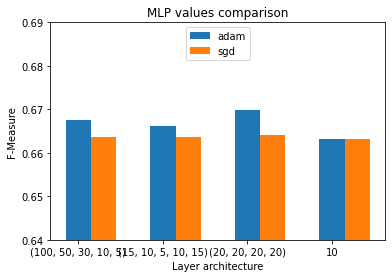

best result for: optimizer = adam, layer = (20, 20, 20, 20), F-measure = 0.669861


In [36]:
# plot the results
width = 0
for i in mlp_fmeasures.keys():
    fmeasures = mlp_fmeasures[i]
    plt.bar(np.arange(len(fmeasures))+width, fmeasures, width=0.3, label=optimizers[i])
    width += 0.3

plt.xticks(range(len(layers)), layers)
plt.legend(loc ='upper center')
plt.title('MLP values comparison')
plt.xlabel('Layer architecture')
plt.ylabel('F-Measure')
plt.ylim(0.64, 0.69)
plt.show()

# print best model parameters
params = mlp_best_model.get_params()
print('best result for: optimizer = %s, layer = %s, F-measure = %f' % (params['solver'], params['hidden_layer_sizes'], mlp_best_result))


---
# ***Final Evaluation***
runnig the best models from each technique on the test set.

In [37]:
# ran the best models from each technique on the test set
knn_pred = knn_best_model.predict(test_x)
svm_pred = svm_best_model.predict(test_x)
dt_pred = dt_best_model.predict(test_x)
rf_pred = rf_best_model.predict(test_x)
mlp_pred = mlp_best_model.predict(test_x)

# get results
final_fmeasures = {}
final_fmeasures['knn'] = get_Fmeasure(knn_pred, test_y)
final_fmeasures['svm'] = get_Fmeasure(svm_pred, test_y)
final_fmeasures['decision tree'] = get_Fmeasure(dt_pred, test_y)
final_fmeasures['rand forest'] = get_Fmeasure(rf_pred, test_y)
final_fmeasures['mlp'] = get_Fmeasure(mlp_pred, test_y)

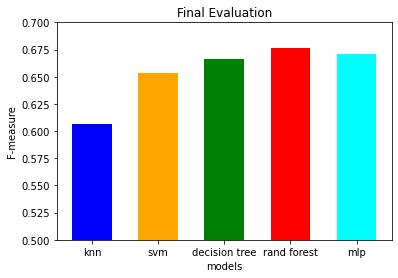


               precision    recall  f1-score   support

           0       0.98      0.85      0.91     16389
           1       0.53      0.93      0.68      3055

    accuracy                           0.86     19444
   macro avg       0.76      0.89      0.79     19444
weighted avg       0.91      0.86      0.87     19444



In [38]:
from sklearn.metrics import classification_report

# plot all the results
plt.bar(final_fmeasures.keys(), final_fmeasures.values(), color=['blue', 'orange', 'green', 'red', 'cyan'], width=.6)
plt.title('Final Evaluation')
plt.xlabel('models')
plt.ylabel('F-measure')
plt.ylim(0.5, 0.7)
plt.show()

# print best model results
print('\n', classification_report(test_y, rf_pred))